In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(3, 51174)

In [4]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'Presto' in col]

['Median PrestoKNe_presto_color_detect UserPointsSlicer',
 'Median PrestoKNe_score_p UserPointsSlicer',
 'Median PrestoKNe_score_s UserPointsSlicer',
 'Sum PrestoKNe_presto_color_detect UserPointsSlicer',
 'Sum PrestoKNe_score_p UserPointsSlicer',
 'Sum PrestoKNe_score_s UserPointsSlicer']

In [5]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'FF u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'FF g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'FF r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'FF i',
    'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
             'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            #}
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'FF u': '',
         'FF g': '',
         'FF r': '',
         'FF i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
#            'Sum SNNSNMetric DD:WFD_reducen_sn DD:WFD all bands, only DDF observations HealpixSubsetSlicer' : 'N SN WFD',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
#            'Median SNNSNMetric DD:WFD_reducezlim DD:WFD all bands, only DDF observations HealpixSubsetSlicer': 'zlim WFD',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 



In [6]:
[col for col in data_loaded.columns if 'Sum SNNSNMetric DD:' in col]

['Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer',
 'Sum SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer',
 'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer',
 'Sum SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer',
 'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer',
 'Sum SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer',
 'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer',
 'Sum SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer',
 'Sum SNNSNMetric DD:WFD_reducen_sn DD:WFD all bands, only DDF observations HealpixSubsetSlicer',
 'Sum SNNSNMetric DD:WFD_reducezlim DD:WFD all bands, only DDF observations He

In [7]:
#data['KNe single model'] # data['KNe ZTF simple']

In [8]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [9]:
mag_data

,g,i,r,u,y,z
filter_u_y_v3.1_10yrs,26.688689,26.295205,26.809752,25.619284,24.765767,25.584335
filter_u_z_v3.1_10yrs,26.692658,26.282547,26.826725,25.635601,24.776856,25.561564
filter_u_zy_v3.1_10yrs,26.696522,26.280475,26.811614,25.622221,24.780784,25.566586


In [10]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS,Kne COSMOS,Kne ECDFS,Kne EDFS,Kne ELAISS1,Kne WFD,Kne XMM_LSS
filter_u_y_v3.1_10yrs,452.542667,80.017748,214.477253,75.567790,109.057917,0.588334,0.586219,0.521403,0.588983,0.554800,368.0,375.0,457.0,347.0,295.0,342.0
filter_u_z_v3.1_10yrs,445.725384,69.724318,213.532164,79.823685,94.410211,0.581173,0.587997,0.506020,0.577380,0.543449,383.0,386.0,486.0,329.0,312.0,346.0
filter_u_zy_v3.1_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767,368.0,361.0,426.0,357.0,293.0,321.0


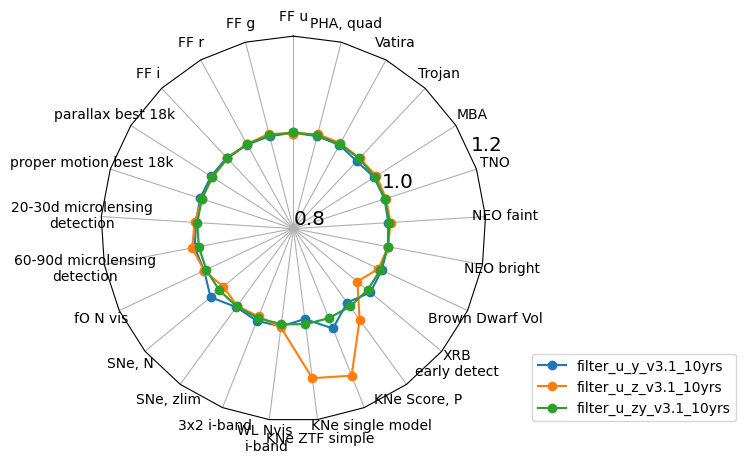

In [11]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='filter_u_zy_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.2], bbox_to_anchor=(1.65, 0))

In [12]:
pd.set_option('display.max_columns', None)
data.loc[runs]

,FF u,FF g,FF r,FF i,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N","SNe, zlim",3x2 i-band,WL Nvis \ni-band,KNe ZTF simple,KNe single model,"KNe Score, P",XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
filter_u_y_v3.1_10yrs,0.976562,0.980235,0.996170,0.998147,0.779844,0.184722,0.3370,0.4721,809.0,123834.701059,0.307189,39.457217,430.0,3450.0,5490.0,232.980919,2096.0,173930.909299,0.9388,0.639774,0.720008,0.924147,0.590819,0.4428,0.868568
filter_u_z_v3.1_10yrs,0.974609,0.985300,0.997529,0.996170,0.782747,0.185466,0.3397,0.4776,809.0,119696.080162,0.303874,39.071949,431.0,3882.0,6056.0,243.348206,2023.0,172644.548557,0.9394,0.644416,0.723349,0.930032,0.599102,0.4472,0.872526
filter_u_zy_v3.1_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,0.305456,39.214641,428.0,3487.0,5366.0,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906


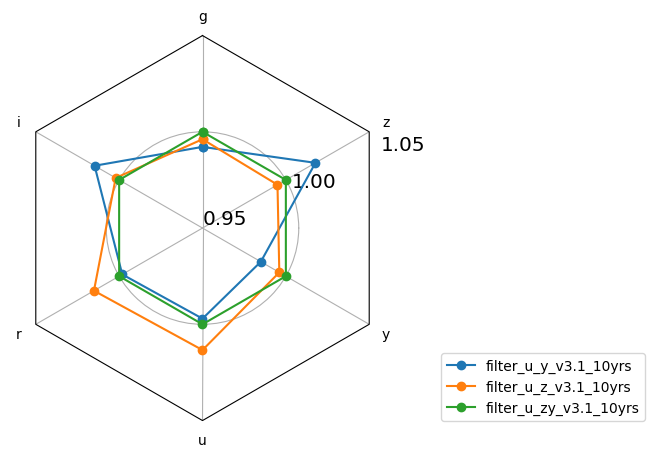

In [13]:

ndata = norm_df(mag_data, runs, cols=mag_data.columns.values.tolist(),
                mag_cols='all', norm_run='filter_u_zy_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.95, 1.0, 1.05], bbox_to_anchor=(1.65, 0))

In [14]:
mag_data.loc[runs]

,g,i,r,u,y,z
filter_u_y_v3.1_10yrs,26.688689,26.295205,26.809752,25.619284,24.765767,25.584335
filter_u_z_v3.1_10yrs,26.692658,26.282547,26.826725,25.635601,24.776856,25.561564
filter_u_zy_v3.1_10yrs,26.696522,26.280475,26.811614,25.622221,24.780784,25.566586


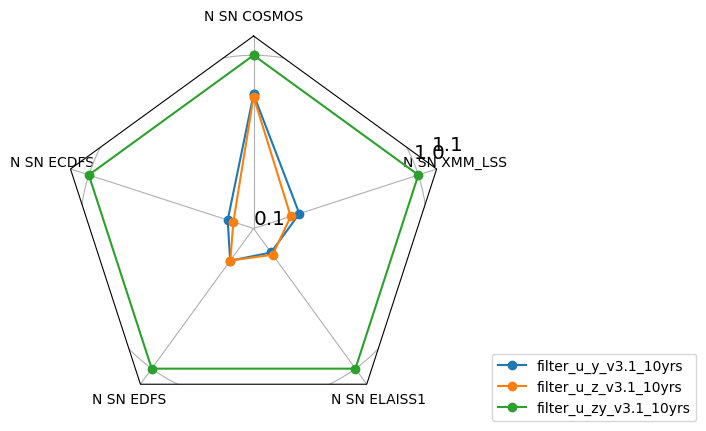

In [15]:
cols = [col for col in ddf_data.columns.values.tolist() if 'N SN' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='filter_u_zy_v3.1_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.1, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [16]:
ddf_data

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS,Kne COSMOS,Kne ECDFS,Kne EDFS,Kne ELAISS1,Kne WFD,Kne XMM_LSS
filter_u_y_v3.1_10yrs,452.542667,80.017748,214.477253,75.567790,109.057917,0.588334,0.586219,0.521403,0.588983,0.554800,368.0,375.0,457.0,347.0,295.0,342.0
filter_u_z_v3.1_10yrs,445.725384,69.724318,213.532164,79.823685,94.410211,0.581173,0.587997,0.506020,0.577380,0.543449,383.0,386.0,486.0,329.0,312.0,346.0
filter_u_zy_v3.1_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767,368.0,361.0,426.0,357.0,293.0,321.0


# SNe redshift limits in the DDFs. No big changes

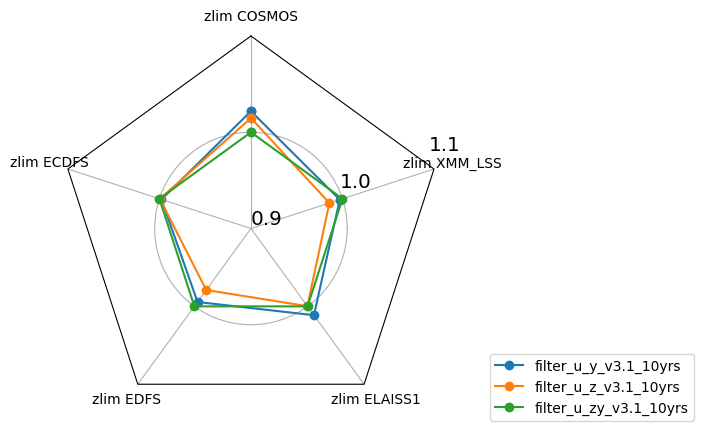

In [17]:
cols = [col for col in ddf_data.columns.values.tolist() if 'zlim' in col]

ndata = norm_df(ddf_data, runs, cols=cols,
                norm_run='filter_u_zy_v3.1_10yrs', mag_cols='all')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [18]:
ddf_ = {}
for filtername in 'ugrizy':
    for ddf_name in ['COSMOS', 'XMM_LSS', 'ELAISS1', 'EDFS', 'ECDFS']:
        ddf_['%s, %s' % (ddf_name, filtername)] = 'Median DD:%s CoaddM5 %s band HealpixSubsetSlicer' % (ddf_name, filtername)
        
ddf_mags = pd.DataFrame()
for key in ddf_:
    ddf_mags[key] = data_loaded[ddf_[key]]
 

In [19]:
ddf_mags

,"COSMOS, u","XMM_LSS, u","ELAISS1, u","EDFS, u","ECDFS, u","COSMOS, g","XMM_LSS, g","ELAISS1, g","EDFS, g","ECDFS, g","COSMOS, r","XMM_LSS, r","ELAISS1, r","EDFS, r","ECDFS, r","COSMOS, i","XMM_LSS, i","ELAISS1, i","EDFS, i","ECDFS, i","COSMOS, z","XMM_LSS, z","ELAISS1, z","EDFS, z","ECDFS, z","COSMOS, y","XMM_LSS, y","ELAISS1, y","EDFS, y","ECDFS, y"
filter_u_y_v3.1_10yrs,27.295284,26.913183,26.977279,26.782260,27.048425,28.510615,28.153973,28.236857,28.046267,28.321046,28.463723,28.095939,28.190612,28.008000,28.245175,28.023179,27.685842,27.754632,27.578546,27.822779,27.517060,27.173208,27.219095,27.027915,27.279378,26.197104,25.949825,25.989865,25.821480,26.048986
filter_u_z_v3.1_10yrs,27.293271,26.921713,26.994170,26.787061,27.049289,28.512297,28.152539,28.241354,28.056152,28.317581,28.464684,28.104631,28.183214,28.021803,28.239394,28.021015,27.682166,27.752488,27.575406,27.819380,27.152838,26.897660,26.919660,26.760065,26.985281,26.521553,26.199782,26.264873,26.057406,26.314442
filter_u_zy_v3.1_10yrs,27.303151,26.919865,26.985079,26.782817,27.056197,28.512062,28.146931,28.230614,28.055793,28.311671,28.465347,28.105789,28.194433,28.011744,28.242855,28.022907,27.681618,27.762329,27.580586,27.821635,27.432896,27.120895,27.178415,27.000636,27.242915,26.460650,26.155556,26.212680,26.013474,26.268678
